# 00 - Explore SORN Package

This Notebook aims at exploring the capabilities of [the SORN package](https://github.com/Saran-nns/sorn), with instructions [here](https://joss.theoj.org/papers/10.21105/joss.03545).

**What is it?**

It is a Python package implementing, what appears to be, a robust but flexible structural framework for experimenting with Self-organized recurrent networks. Furthermore, it is efficiently written in a vectorized way which should optimize runtime.

**What is the goal of this notebook?**

The goal of this Notebook is to

1. implement some examples from the docs
2. re-implement the E-I network used in [this paper](http://www.diva-portal.se/smash/get/diva2:1371426/FULLTEXT01.pdf)


The terminology used in this notebook refers to this image (from the SORN docs)

<p align="center">
    <img src=./../img/sorn_reservoir_overview.png width=600px />
</p>


## 0. Configuration


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

plt.style.use(["science", "no-latex"])
mpl.rcParams["font.serif"] = ["Times New Roman"]


## 1. Implementing the doc example


#### Plasticity phase


In [3]:
import sorn
from sorn import Simulator
import numpy as np

# Sample input
num_features = 100
time_steps = 200
inputs = np.random.rand(num_features, time_steps)

# Simulate the network with default hyperparameters under gaussian white noise
state_dict, sim_dict = Simulator.run(
    inputs=inputs,
    nu=num_features,
    ne=num_features * 2,
    phase="plasticity",
    state=None,
    noise=True,
    timesteps=time_steps,
    callbacks=["ExcitatoryActivation", "WEE", "EEConnectionCounts"],
)


2023-03-26 14:58:30,014:INFO:Network Initialized
2023-03-26 14:58:30,016:INFO:Number of connections in Wee 3916 , Wei 1583, Wie 8000
2023-03-26 14:58:30,016:INFO:Shapes Wee (200, 200) Wei (40, 200) Wie (200, 40)
100%|██████████| 200/200 [00:02<00:00, 69.31it/s]


**The dicts contains the following:**

- `state_dict` - Dictionary of connection weights (`Wee`, `Wei`, `Wie`) , Excitatory network activity (`X`), Inhibitory network activities(`Y`), Threshold values (`Te`, `Ti`)

- `sim_dict` - Dictionary of network states and parameters collected during the simulation/training: Provided, all available options of the argument `callbacks`, then the `sim_dict` should contain the following;


In [4]:
print(state_dict.keys())
print(sim_dict.keys())


dict_keys(['Wee', 'Wei', 'Wie', 'Te', 'Ti', 'X', 'Y'])
dict_keys(['WEE', 'ExcitatoryActivation', 'EEConnectionCounts'])


**And the acronyms means the following:**

- "ExcitatoryActivation" - Excitatory network activity of entire simulation period

- "InhibitoryActivation" - Inhibitory network activity of entire simulation period

- "RecurrentActivation" - Recurrent network activity of entire simulation period

- "EEConnectionCounts" - Number of active connections in the Excitatory pool at each time step

- "EIConnectionCounts" - Number of active connections from Inhibitory to Excitatory pool at each time step

- "TE" - Threshold values of excitatory neurons at each time step

- "TI" - Threshold values of inhibitory neurons at each time step

- "WEE" - Synaptic efficacies between excitatory neurons

- "WEI" - Connection weights from inhibitory to excitatory neurons

- "WIE" - Connection weights from excitatory to inhibitory neurons


### Training phase


In [56]:
from sorn import Trainer

# NOTE: During training phase, input to `sorn` should have second (time) dimension set to 1. ie., input shape should be (input_features,1).

inputs_flatten = np.random.rand(num_features, 1)

# SORN network is frozen during training phase
""" state_dict, sim_dict = Trainer.run(
    inputs=inputs_flatten,
    phase="training",
    state=state_dict,
    noise=False,
    timesteps=1,
    ne=100,
    nu=num_features,
    lambda_ee=10,
    eta_stdp=0.001,
    callbacks=["InhibitoryActivation", "WEI", "EIConnectionCounts"],
) """


' state_dict, sim_dict = Trainer.run(\n    inputs=inputs_flatten,\n    phase="training",\n    state=state_dict,\n    noise=False,\n    timesteps=1,\n    ne=100,\n    nu=num_features,\n    lambda_ee=10,\n    eta_stdp=0.001,\n    callbacks=["InhibitoryActivation", "WEI", "EIConnectionCounts"],\n) '

### Plotting functions


**Plot weight distribution in the network**


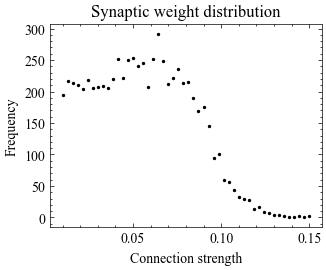

In [85]:
from sorn import Plotter

# For example, the network has 200 neurons in the excitatory pool.
Wee = state_dict["Wee"]  # state_dict['Wee'] returned by the SORN is already normalized
Plotter.weight_distribution(weights=Wee, bin_size=50, savefig=True)


**Plot Spike train**


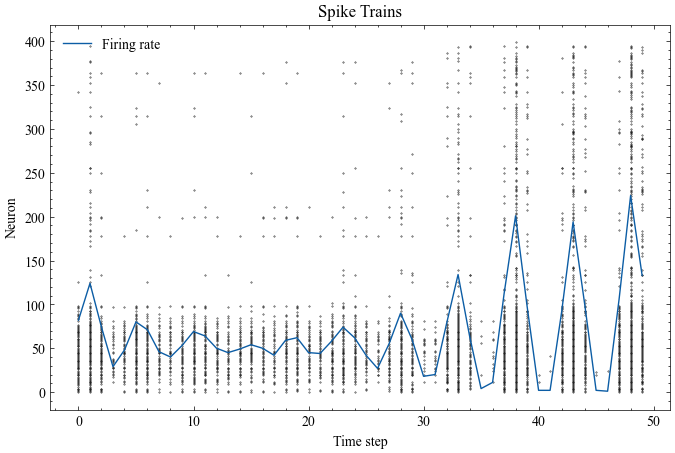

In [86]:
E = np.array(sim_dict["ExcitatoryActivation"])

Plotter.scatter_plot(spike_train=E, savefig=True)


**Raster plot of Spike train**


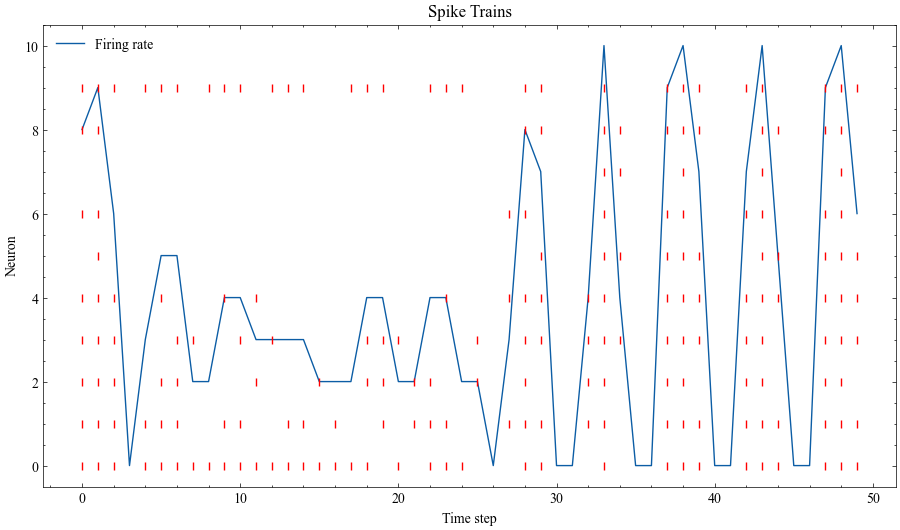

In [87]:
# Raster plot of activity of only first 10 neurons in the excitatory pool
Plotter.raster_plot(spike_train=E[:, 0:10], savefig=True)


**Distribution of presynaptic connections**


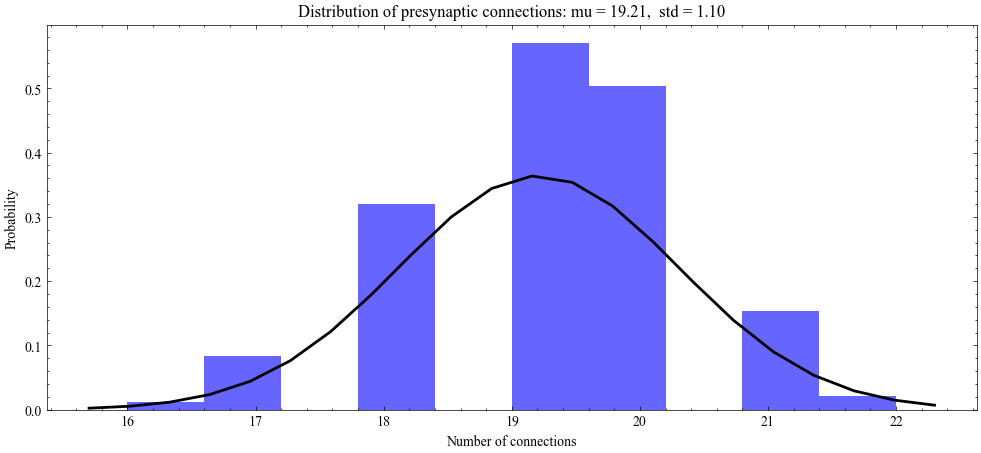

In [88]:
# Histogram of number of presynaptic connections per neuron in the excitatory pool
Plotter.hist_incoming_conn(
    weights=Wee,
    bin_size=10,
    histtype="bar",
    savefig=True,
)


**Distribution of firing rate of the network**


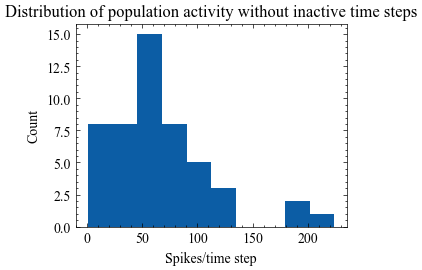

In [89]:
Plotter.hist_firing_rate_network(
    E,
    bin_size=10,
    savefig=True,
)


**Plot pearson correlation between neurons**


c:\Users\hanne\Documents\KEX-project\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\hanne\Documents\KEX-project\.venv\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


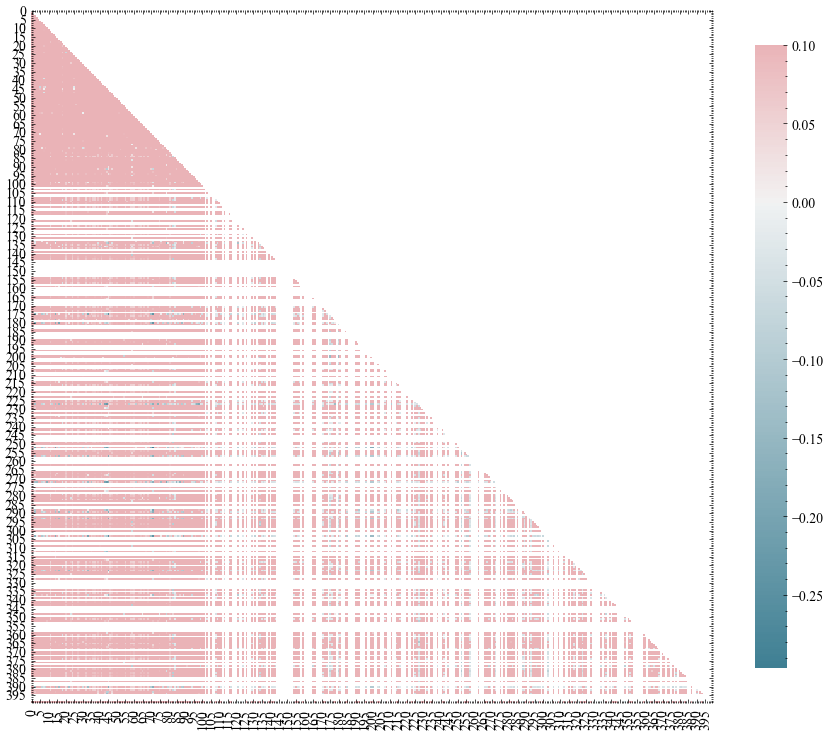

In [90]:
from sorn import Statistics

avg_corr_coeff, _ = Statistics.avg_corr_coeff(E)
Plotter.correlation(avg_corr_coeff, savefig=True)


**Linear and Lognormal curve fit of Synaptic weights**


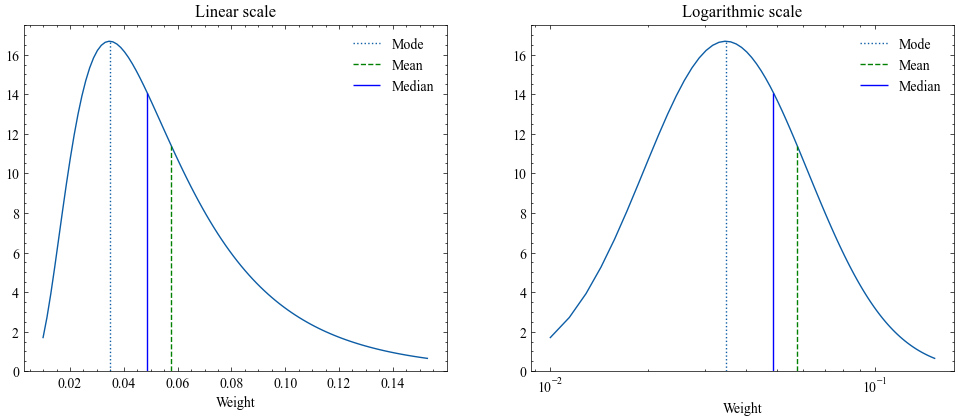

In [91]:
# Distribution of connection weights in linear and lognormal scale
Plotter.linear_lognormal_fit(weights=Wee, num_points=100, savefig=True)


**Network plot**


In [93]:
# Draw network connectivity using the pearson correlation function between neurons in the excitatory pool
# Plotter.plot_network(avg_corr_coeff, corr_thres=0.01, fig_name="network.png")


### Statistics and Analysis functions


**t-lagged auto correlation between neural activity**


In [95]:
from sorn import Statistics

pearson_corr_matrix = Statistics.autocorr(firing_rates=[1, 1, 5, 6, 3, 7], t=2)
pearson_corr_matrix


array([[ 1.        , -0.01855355],
       [-0.01855355,  1.        ]])

**Spike Source Entropy**


In [97]:
# Measure the uncertainty about the origin of spike from the network using entropy
sse = Statistics.spike_source_entropy(spike_train=E, num_neurons=200)
sse


nan

## 2. Re-implementing original E-I Network


**Config**


In [234]:
# Input parameters
IMG_WIDTH = 10  # Pixels
N_OF_IMAGES = 10

# Network parameters
N_INPUT_CONNECTIONS = IMG_WIDTH ** 2
N_EXCITATORY_CELLS = 400
N_INHIBITORY_CELLS = 49

TIME_STEPS = 5000

**2a Image generation**

The paper uses images, looking like the following:


In [258]:
import numpy as np


def normalize_array(array):
    array_norm = (array - np.min(array)) / (np.max(array) - np.min(array))
    return array_norm


def generate_image_data(
    img_width: int, noise_alpha: float = 0, seed: int = None
) -> np.array:
    if seed != None:
        np.random.seed(seed)
    seed_1, seed_2 = np.random.rand(2) * 2
    max_value = 2

    theta = np.arange(0, max_value, max_value / img_width) - seed_1
    theta_array = (1 - noise_alpha) * np.tensordot(
        theta, theta + seed_2, axes=0
    ) + noise_alpha * np.random.rand(img_width, img_width)
    value_array = np.sin(theta_array)
    img_data = np.cos(value_array)
    return normalize_array(img_data)


def plot_sample_image(img_data, title: str):
    img_width = len(img_data)
    ticks_enumerator = np.arange(0, img_width + 1, img_width / 4)
    plt.imshow(img_data, vmin=0, vmax=1)
    plt.xticks(ticks_enumerator)
    plt.yticks(ticks_enumerator)
    plt.title(title, pad=10)

    plt.gray()

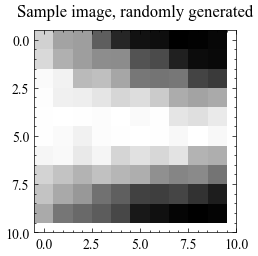

In [261]:
img_data_list = [
    generate_image_data(
        IMG_WIDTH,
        noise_alpha=0.25,
        # seed=12,
    )
    for i in range(10)
]

sample_image = img_data_list[3]
plot_sample_image(sample_image, title="Sample image, randomly generated")

**2b Learning _without_ an explicit criticality mechanism**


The input vector is one the form:

```bash
[                   input  
    [       ],      nodes
    [       ],         |
    [       ],         |
]                      V 

timesteps ->
```

In [265]:
def flatten_image_patch(image_patch):
    flattened_length = np.shape(image_patch)[0] * np.shape(image_patch)[1]
    return np.reshape(image_patch, (flattened_length, 1))

def generate_input_sequence(
    image_patch: np.array, time_steps: int, n_input_connections: int
) -> np.array:
    input_vector = flatten_image_patch(image_patch)
    assert (
        len(input_vector) == n_input_connections
    ), "Input size doesn't match # of input neurons"

    input_vector_sequence = np.tile(input_vector, time_steps)
    assert (
        len(input_vector_sequence[0]) == time_steps
    ), "Input sequence doesnt span the full time step range"
    return input_vector_sequence


input_vector_sequence = generate_input_sequence(
    image_patch=sample_image,
    time_steps=TIME_STEPS,
    n_input_connections=N_INPUT_CONNECTIONS,
)

In [263]:
import sorn
from sorn import Simulator
import numpy as np

# Simulate the network with default hyperparameters under gaussian white noise
state_dict, sim_dict = Simulator.run(
    inputs=input_vector_sequence,
    nu=N_INPUT_CONNECTIONS,
    ne=N_EXCITATORY_CELLS,
    ni=N_INHIBITORY_CELLS,
    phase="plasticity",
    state=None,
    # noise=True,
    timesteps=TIME_STEPS,
    callbacks=["ExcitatoryActivation", "WEE", "EEConnectionCounts"],
)

2023-03-27 10:45:05,117:INFO:Network Initialized
2023-03-27 10:45:05,118:INFO:Number of connections in Wee 7805 , Wei 3158, Wie 32000
2023-03-27 10:45:05,119:INFO:Shapes Wee (400, 400) Wei (80, 400) Wie (400, 80)
100%|██████████| 5000/5000 [03:54<00:00, 21.35it/s]


**2c. Reconstruct the image samples**

In [277]:
def reconstruct_input_vector(
    n_input_neurons: int, connection_weights: np.array, spike_train: np.array
):
    """Reconstruct the original image using the method described
    in the E-I Paper:

    * The image patch is reconstructed as the sum of the {input -> E-neuron}-weights
    * multiplied by the respective E-cell spike rates.

    * The reconstructed image patch was then normalized to unit SD to match the
    variance of the input patches.
    * The RMS residual error measure is then the RMS of the difference between
    original image patch pixels and reconstructed pixels.
    """

    reconstructed_input_vector = []

    for input_idx in range(n_input_neurons):
        input_neuron_activation = 0
        outgoing_connection_idx = connection_weights[input_idx].nonzero()
        for outgoing_idx in outgoing_connection_idx[0]:
            outgoing_weight = connection_weights[input_idx][outgoing_idx]
            _, _, E_spike_rate = Statistics.firing_rate_neuron(
                spike_train=spike_train, neuron=outgoing_idx, bin_size=1
            )
            reconstructed_activation = outgoing_weight * E_spike_rate

            input_neuron_activation += reconstructed_activation

        reconstructed_input_vector.append(input_neuron_activation)
    return np.array(reconstructed_input_vector)


def compute_reconstructed_RMS(
    original_input_vector: np.array, reconstructed_input_vector: np.array
) -> np.array:
    error = original_input_vector - reconstructed_input_vector
    RMSE = np.sqrt(np.mean(error**2))
    return RMSE

In [278]:
connection_weights = state_dict["Wee"]
spike_train = np.array(sim_dict["ExcitatoryActivation"])

reconstructed_input_vector = reconstruct_input_vector(
    n_input_neurons=N_INPUT_CONNECTIONS,
    connection_weights=connection_weights,
    spike_train=spike_train,
)

reconstructed_input_vector = normalize_array(reconstructed_input_vector)

input_vector = flatten_image_patch(sample_image)
reconstructed_RMSE = compute_reconstructed_RMS(
    original_input_vector=input_vector,
    reconstructed_input_vector=reconstructed_input_vector,
)

print(f"reconstructed_RMSE: {reconstructed_RMSE}")

reconstructed_RMSE: 0.6313474798028368


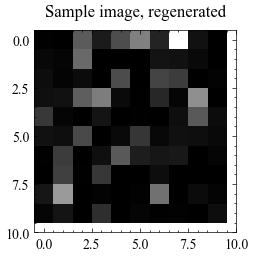

In [279]:
reconstructed_image_patch = reconstructed_input_vector.reshape(IMG_WIDTH, IMG_WIDTH)
plot_sample_image(reconstructed_image_patch, title="Sample image, regenerated")


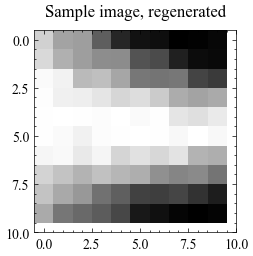

In [280]:
plot_sample_image(sample_image, title="Sample image, regenerated")
